# Heart Disease Risk Prediction – Logistic Regression (from scratch)

Tarea práctica de regresión logística sin usar scikit-learn para el entrenamiento (solo NumPy/Pandas/Matplotlib). Incluye EDA, modelos básicos, regularización y notas de despliegue en Amazon SageMaker.

- Dataset: UCI Heart Disease (303 filas, 14 columnas), descarga desde Kaggle (`https://www.kaggle.com/datasets/neurocipher/heartdisease`).

- Objetivo: predecir presencia de enfermedad cardiaca (`target` binario).

- Entregables: notebook ejecutable con gráficos/tablas y README con resumen y evidencias de despliegue.


In [27]:
# Librerías principales
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

# Limpiar cache de fuentes corrupto (soluciona "font not found")
try:
    import shutil
    cache_dir = matplotlib.get_cachedir()
    fontlist_file = Path(cache_dir) / 'fontlist-v330.json'
    if fontlist_file.exists():
        fontlist_file.unlink()
except Exception:
    pass

# Recargar font_manager para reconstruir fuentes
matplotlib.font_manager.fontManager = matplotlib.font_manager.FontManager()

# Configurar matplotlib para evitar símbolos LaTeX problemáticos
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.default'] = 'regular'

# Configuración de gráficos con fallback robusto
for style_name in ['seaborn-v0_8', 'seaborn', 'ggplot', 'default']:
    try:
        plt.style.use(style_name)
        break
    except Exception:
        continue
%matplotlib inline

DATA_PATH = Path('Heart_Disease_Prediction.csv')

# Ajustes para display
pd.set_option('display.max_columns', 30)
pd.set_option('display.precision', 3)

## Paso 1: Carga, exploración y preparación de datos
- Carga del CSV y verificación de columnas.
- Binarización del `target` (1 = enfermedad, 0 = sano).
- Estadísticos descriptivos, valores faltantes y distribución de clases.
- División estratificada 70/30 y normalización (z-score) de variables numéricas.


In [28]:
# Carga del dataset
assert DATA_PATH.exists(), f"No se encontró el archivo {DATA_PATH}"
raw_df = pd.read_csv(DATA_PATH)
# Normalizar nombres de columnas a minúsculas y sin espacios
raw_df.columns = raw_df.columns.str.strip().str.lower()
print(f"Shape original: {raw_df.shape}")
print(f"Columnas normalizadas: {list(raw_df.columns)}")

# Detectar y binarizar columna objetivo
possible_targets = ['target', 'num']
target_col = None
for col in possible_targets:
    if col in raw_df.columns:
        target_col = col
        break
if target_col is None:
    target_col = raw_df.columns[-1]  # fallback al último

# Binarizar la columna objetivo aunque venga como texto
col = raw_df[target_col]
col_numeric = pd.to_numeric(col, errors='coerce')
if col_numeric.notna().all():
    target_clean = (col_numeric > 0).astype(int)
else:
    col_lower = col.astype(str).str.strip().str.lower()
    map_dict = {
        '1': 1, 'yes': 1, 'y': 1, 'true': 1, 'present': 1, 'disease': 1, 'presence': 1,
        '0': 0, 'no': 0, 'n': 0, 'false': 0, 'absent': 0, 'absence': 0
    }
    target_mapped = col_lower.map(map_dict)
    if target_mapped.isna().any():
        uniques = col_lower.unique()
        raise ValueError(f"No se pudo binarizar target. Revisa valores: {uniques}")
    target_clean = target_mapped.astype(int)

raw_df[target_col] = target_clean
raw_df = raw_df.rename(columns={target_col: 'target'})

# Vista rápida
raw_df.head()


Shape original: (270, 14)
Columnas normalizadas: ['age', 'sex', 'chest pain type', 'bp', 'cholesterol', 'fbs over 120', 'ekg results', 'max hr', 'exercise angina', 'st depression', 'slope of st', 'number of vessels fluro', 'thallium', 'heart disease']


,age,sex,chest pain type,bp,cholesterol,fbs over 120,ekg results,max hr,exercise angina,st depression,slope of st,number of vessels fluro,thallium,target
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0


Valores faltantes por columna:


,missing,mean,std,min,max
age,0,54.433,9.109,29.0,77.0
sex,0,0.678,0.468,0.0,1.0
chest pain type,0,3.174,0.950,1.0,4.0
bp,0,131.344,17.862,94.0,200.0
cholesterol,0,249.659,51.686,126.0,564.0
fbs over 120,0,0.148,0.356,0.0,1.0
ekg results,0,1.022,0.998,0.0,2.0
max hr,0,149.678,23.166,71.0,202.0
exercise angina,0,0.330,0.471,0.0,1.0
st depression,0,1.050,1.145,0.0,6.2


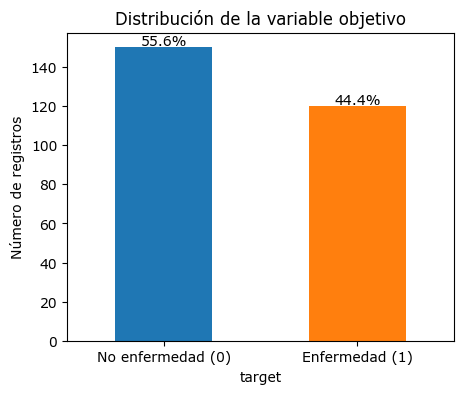

In [29]:
# EDA básica
summary = raw_df.describe().T
missing = raw_df.isnull().sum().rename('missing')
class_counts = raw_df['target'].value_counts().sort_index()
class_pct = (class_counts / len(raw_df)).rename('pct') * 100

print("Valores faltantes por columna:")
display(pd.concat([missing, summary[['mean', 'std', 'min', 'max']]], axis=1))

fig, ax = plt.subplots(figsize=(5,4))
class_counts.plot(kind='bar', ax=ax, color=['tab:blue','tab:orange'])
ax.set_xticklabels(['No enfermedad (0)','Enfermedad (1)'], rotation=0)
ax.set_ylabel('Número de registros')
ax.set_title('Distribución de la variable objetivo')
for p, pct in zip(ax.patches, class_pct):
    ax.annotate(f"{pct:.1f}%", (p.get_x() + p.get_width()/2, p.get_height()+1), ha='center')
plt.show()


In [30]:
# División estratificada 70/30 y normalización

def stratified_train_test_split(df, test_size=0.3, random_state=42):
    np.random.seed(random_state)
    train_idx, test_idx = [], []
    for label, group in df.groupby('target'):
        idx = group.index.to_numpy()
        np.random.shuffle(idx)
        split = int(len(idx) * (1 - test_size))
        train_idx.extend(idx[:split])
        test_idx.extend(idx[split:])
    train_df = df.loc[train_idx].sample(frac=1, random_state=random_state)
    test_df = df.loc[test_idx].sample(frac=1, random_state=random_state)
    return train_df, test_df

# Filtrar solo columnas numéricas
all_features = [c for c in raw_df.columns if c != 'target' and pd.api.types.is_numeric_dtype(raw_df[c])]

def pick_features(candidates=('age','trestbps','chol','thalach','oldpeak','ca')):
    available = [c for c in candidates if c in all_features]
    if len(available) >= 6:
        return available[:6]
    # fallback: take first 6 numeric features available
    return all_features[:min(6, len(all_features))]

selected_features = pick_features()
print(f"Usando características: {selected_features}")

train_df, test_df = stratified_train_test_split(raw_df, test_size=0.3, random_state=123)

# Normalización z-score sobre train
feature_mean = train_df[selected_features].mean()
feature_std = train_df[selected_features].std().replace(0, 1)

def transform(df):
    x = (df[selected_features] - feature_mean) / feature_std
    y = df['target'].values.reshape(-1, 1)
    return x.values, y

X_train, y_train = transform(train_df)
X_test, y_test = transform(test_df)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Usando características: ['age', 'sex', 'chest pain type', 'bp', 'cholesterol', 'fbs over 120']
Train shape: (189, 6), Test shape: (81, 6)


In [31]:
# Paso 2: Implementación de regresión logística desde cero

def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def compute_cost(w, b, X, y, reg_lambda=0.0):
    m = X.shape[0]
    z = X @ w + b
    a = sigmoid(z)
    epsilon = 1e-8  # estabilidad numérica
    cost = - (1/m) * np.sum(y * np.log(a + epsilon) + (1 - y) * np.log(1 - a + epsilon))
    if reg_lambda > 0:
        cost += (reg_lambda / (2*m)) * np.sum(w**2)
    return cost


def compute_gradients(w, b, X, y, reg_lambda=0.0):
    m = X.shape[0]
    z = X @ w + b
    a = sigmoid(z)
    dz = a - y
    dw = (1/m) * (X.T @ dz) + (reg_lambda/m) * w
    db = (1/m) * np.sum(dz)
    return dw, db


def gradient_descent(X, y, alpha=0.01, num_iters=1500, reg_lambda=0.0, verbose=False):
    n_features = X.shape[1]
    w = np.zeros((n_features, 1))
    b = 0.0
    cost_history = []

    for i in range(num_iters):
        dw, db = compute_gradients(w, b, X, y, reg_lambda)
        w -= alpha * dw
        b -= alpha * db
        if i % 50 == 0 or i == num_iters - 1:
            cost = compute_cost(w, b, X, y, reg_lambda)
            cost_history.append(cost)
            if verbose and i % 200 == 0:
                print(f"Iter {i}: cost={cost:.4f}")
    return w, b, cost_history


def predict_proba(w, b, X):
    return sigmoid(X @ w + b)


def predict_labels(w, b, X, threshold=0.5):
    return (predict_proba(w, b, X) >= threshold).astype(int)


def classification_metrics(y_true, y_pred):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    m = len(y_true)
    acc = (y_true == y_pred).mean()
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


Métricas (train vs test):


,accuracy,precision,recall,f1
train,0.730,0.704,0.679,0.691
test,0.827,0.806,0.806,0.806


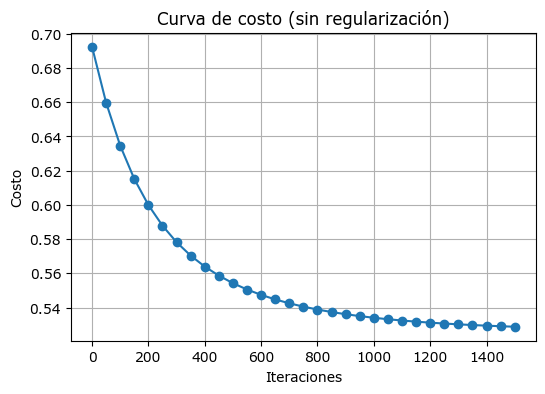

,feature,weight
0,chest pain type,0.924
1,sex,0.641
2,age,0.370
3,cholesterol,0.262
4,bp,0.143
5,fbs over 120,0.024


In [32]:
# Entrenamiento base (sin regularización)
alpha = 0.01
num_iters = 1500
w_base, b_base, cost_history = gradient_descent(X_train, y_train, alpha=alpha, num_iters=num_iters, reg_lambda=0.0, verbose=False)

# Predicciones y métricas
train_pred = predict_labels(w_base, b_base, X_train)
test_pred = predict_labels(w_base, b_base, X_test)
train_metrics = classification_metrics(y_train, train_pred)
test_metrics = classification_metrics(y_test, test_pred)

print("Métricas (train vs test):")
metrics_df = pd.DataFrame([train_metrics, test_metrics], index=['train','test']).round(3)
display(metrics_df)

# Curva de costo
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(len(cost_history))*50, cost_history, marker='o')
ax.set_xlabel('Iteraciones')
ax.set_ylabel('Costo')
ax.set_title('Curva de costo (sin regularización)')
ax.grid(True)
plt.show()

# Coeficientes para interpretación
coef_df = pd.DataFrame({'feature': selected_features, 'weight': w_base.reshape(-1)})
coef_df.sort_values('weight', ascending=False).reset_index(drop=True)


In [33]:
# Paso 3: Visualización de fronteras de decisión (pares de características)

# Elegir pares solo con columnas numéricas disponibles
avail = [c for c in raw_df.columns if c != 'target' and pd.api.types.is_numeric_dtype(raw_df[c])]
if len(avail) < 2:
    raise ValueError("No hay suficientes columnas numéricas para crear pares")
if len(avail) >= 6:
    pair_candidates = [(avail[0], avail[1]), (avail[2], avail[3]), (avail[4], avail[5])]
elif len(avail) >= 4:
    pair_candidates = [(avail[0], avail[1]), (avail[2], avail[3])]
else:
    pair_candidates = [(avail[0], avail[1])]
print(f"Usando pares: {pair_candidates}")


def train_on_pair(pair, reg_lambda=0.0, alpha=0.05, num_iters=2500):
    f1, f2 = pair
    if f1 not in raw_df.columns or f2 not in raw_df.columns:
        raise ValueError(f"Faltan columnas para el par {pair}")
    mean_pair = train_df[[f1, f2]].mean()
    std_pair = train_df[[f1, f2]].std().replace(0, 1)

    def transform_pair(df):
        Xp = (df[[f1, f2]] - mean_pair) / std_pair
        yp = df['target'].values.reshape(-1, 1)
        return Xp.values, yp

    Xtr, ytr = transform_pair(train_df)
    Xte, yte = transform_pair(test_df)
    w, b, cost_hist = gradient_descent(Xtr, ytr, alpha=alpha, num_iters=num_iters, reg_lambda=reg_lambda)
    return w, b, cost_hist, Xtr, ytr, Xte, yte, mean_pair, std_pair


def plot_boundary(ax, X, y, w, b, mean_pair, std_pair, title):
    scatter = ax.scatter(X[:,0], X[:,1], c=y.reshape(-1), cmap='bwr', alpha=0.7, edgecolor='k')
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = predict_labels(w, b, grid).reshape(xx.shape)
    ax.contourf(xx, yy, zz, alpha=0.2, cmap='bwr')
    # Línea de probabilidad 0.5 (compatible con todas las versiones de matplotlib)
    logits = (grid @ w + b).reshape(xx.shape)
    ax.contour(xx, yy, logits, levels=[0], colors='k', linewidths=2)
    # Añadir leyenda manualmente
    from matplotlib.lines import Line2D
    legend_line = Line2D([0], [0], color='k', linewidth=2, label='p=0.5')
    ax.legend(handles=[legend_line])
    ax.set_xlabel('Feature 1 (normalizada)')
    ax.set_ylabel('Feature 2 (normalizada)')
    ax.set_title(title)


def evaluate_pair(pair, reg_lambda=0.0):
    w, b, cost_hist, Xtr, ytr, Xte, yte, mean_pair, std_pair = train_on_pair(pair, reg_lambda=reg_lambda)
    train_pred = predict_labels(w, b, Xtr)
    test_pred = predict_labels(w, b, Xte)
    metrics = {
        'train': classification_metrics(ytr, train_pred),
        'test': classification_metrics(yte, test_pred)
    }
    fig, ax = plt.subplots(figsize=(6,5))
    plot_boundary(ax, Xtr, ytr, w, b, mean_pair, std_pair, title=f"Frontera {pair} (lambda={reg_lambda})")
    plt.show()

    return metrics, cost_hist

Usando pares: [('age', 'sex'), ('chest pain type', 'bp'), ('cholesterol', 'fbs over 120')]


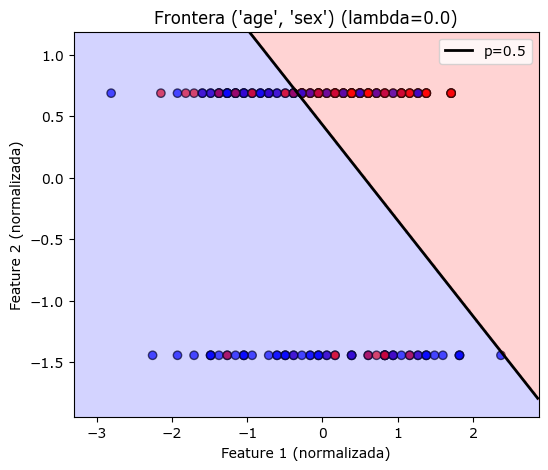

,accuracy,precision,recall,f1
train,0.646,0.605,0.583,0.594
test,0.728,0.706,0.667,0.686


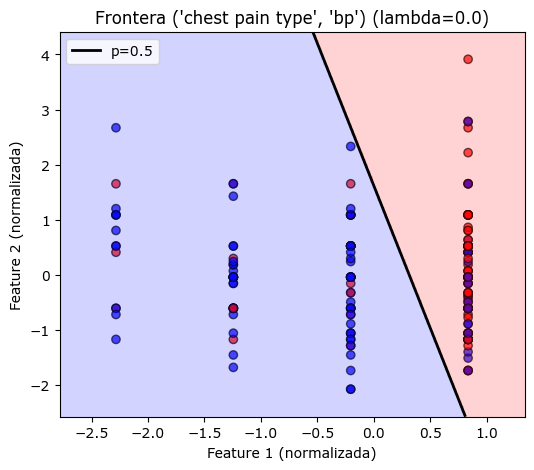

,accuracy,precision,recall,f1
train,0.741,0.684,0.774,0.726
test,0.790,0.771,0.750,0.761


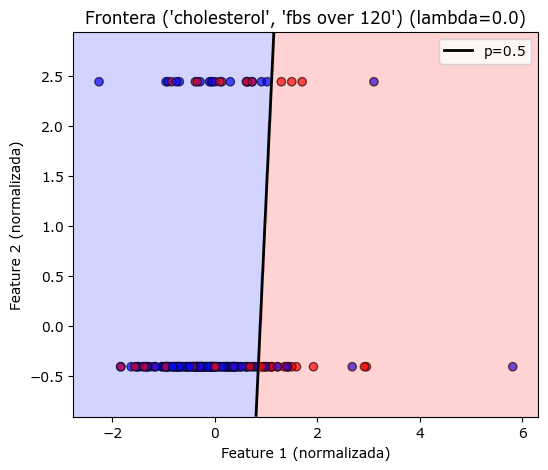

,accuracy,precision,recall,f1
train,0.587,0.600,0.214,0.316
test,0.481,0.312,0.139,0.192


In [34]:
# Ejecutar evaluación en pares disponibles
pair_results = {}
for pair in pair_candidates:
    try:
        metrics, cost_hist = evaluate_pair(pair, reg_lambda=0.0)
        pair_results[pair] = metrics
        display(pd.DataFrame(metrics).T.round(3))
    except ValueError as e:
        print(e)
        continue


,lambda,train_acc,test_acc,test_f1,w_norm
0,0.000,0.730,0.827,0.806,1.222
1,0.001,0.730,0.827,0.806,1.221
2,0.010,0.730,0.827,0.806,1.221
3,0.100,0.730,0.827,0.806,1.218
4,1.000,0.725,0.827,0.806,1.189


Mejor lambda por F1 de test: 0.0


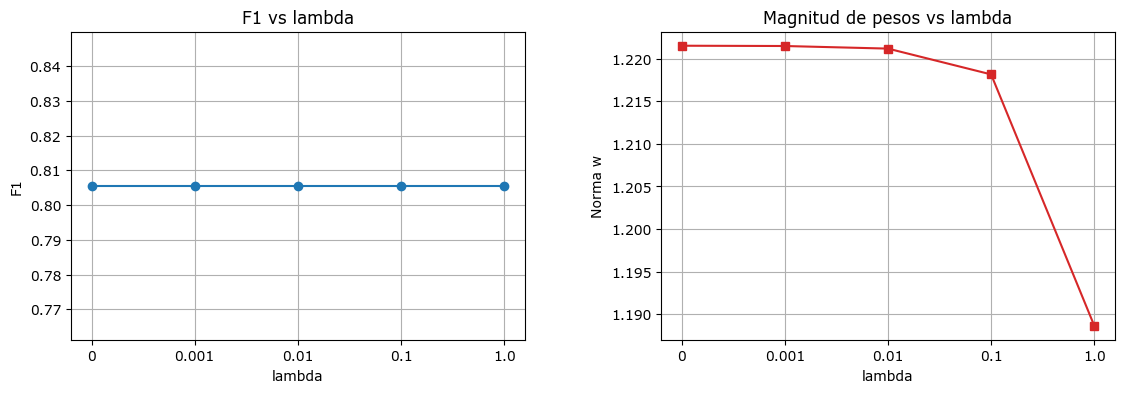

In [35]:
# Paso 4: Regularización L2 y búsqueda de lambda
lambdas = [0, 0.001, 0.01, 0.1, 1.0]
reg_results = []
for lam in lambdas:
    w_lam, b_lam, cost_hist = gradient_descent(X_train, y_train, alpha=alpha, num_iters=num_iters, reg_lambda=lam)
    train_pred = predict_labels(w_lam, b_lam, X_train)
    test_pred = predict_labels(w_lam, b_lam, X_test)
    train_m = classification_metrics(y_train, train_pred)
    test_m = classification_metrics(y_test, test_pred)
    reg_results.append({
        'lambda': lam,
        'train_acc': train_m['accuracy'],
        'test_acc': test_m['accuracy'],
        'test_f1': test_m['f1'],
        'w_norm': np.linalg.norm(w_lam)
    })

reg_df = pd.DataFrame(reg_results)
display(reg_df.round(3))

best_idx = reg_df['test_f1'].idxmax()
best_lambda = reg_df.loc[best_idx, 'lambda']
print(f"Mejor lambda por F1 de test: {best_lambda}")

# Crear figura sin usar tight_layout para evitar problemas de fuentes
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Usar índice para evitar problemas con lambda=0 en escala log
x_ticks = list(range(len(lambdas)))

ax[0].plot(x_ticks, reg_df['test_f1'], marker='o', label='F1 test')
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels([str(l) for l in lambdas])
ax[0].set_xlabel('lambda')
ax[0].set_ylabel('F1')
ax[0].set_title('F1 vs lambda')
ax[0].grid(True)

ax[1].plot(x_ticks, reg_df['w_norm'], marker='s', color='tab:red')
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels([str(l) for l in lambdas])
ax[1].set_xlabel('lambda')
ax[1].set_ylabel('Norma w')  # Texto plano en lugar de ||w||
ax[1].set_title('Magnitud de pesos vs lambda')
ax[1].grid(True)

# Usar subplots_adjust en lugar de tight_layout para evitar problema de fonts
fig.subplots_adjust(left=0.08, right=0.95, wspace=0.3)
plt.show()

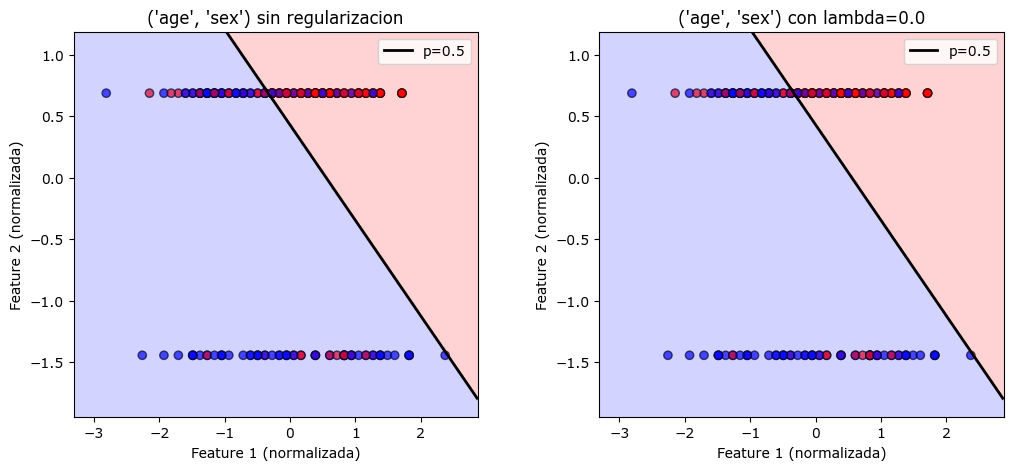

In [36]:
# Comparación de frontera con y sin regularización para un par
pair_to_compare = pair_candidates[0]

w0, b0, _, Xtr0, ytr0, _, _, mean0, std0 = train_on_pair(pair_to_compare, reg_lambda=0.0)
wreg, breg, _, Xtr1, ytr1, _, _, mean1, std1 = train_on_pair(pair_to_compare, reg_lambda=best_lambda)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_boundary(axes[0], Xtr0, ytr0, w0, b0, mean0, std0, title=f"{pair_to_compare} sin regularizacion")
plot_boundary(axes[1], Xtr1, ytr1, wreg, breg, mean1, std1, title=f"{pair_to_compare} con lambda={best_lambda}")
fig.subplots_adjust(wspace=0.3)
plt.show()

In [37]:
# Entrenamiento final con mejor lambda y exportación del modelo
w_best, b_best, cost_best = gradient_descent(X_train, y_train, alpha=alpha, num_iters=num_iters, reg_lambda=best_lambda)
final_train_pred = predict_labels(w_best, b_best, X_train)
final_test_pred = predict_labels(w_best, b_best, X_test)
final_metrics = pd.DataFrame([
    classification_metrics(y_train, final_train_pred),
    classification_metrics(y_test, final_test_pred)
], index=['train','test']).round(3)
print("Métricas finales con lambda óptima:")
display(final_metrics)

np.save('best_w.npy', w_best)
np.save('best_b.npy', np.array([b_best]))
print("Pesos guardados en best_w.npy y best_b.npy")


Métricas finales con lambda óptima:


,accuracy,precision,recall,f1
train,0.730,0.704,0.679,0.691
test,0.827,0.806,0.806,0.806


Pesos guardados en best_w.npy y best_b.npy


## Paso 5: Notas de despliegue en Amazon SageMaker
1) En SageMaker Studio / Notebook Instance (ml.t3.micro basta para pruebas), subir este notebook y el CSV.
2) Ejecutar las celdas de entrenamiento para obtener `best_w.npy` y `best_b.npy`.
3) Crear script de inferencia `inference.py` con:
   - Cargar `best_w.npy` y `best_b.npy` en `model_fn`.
   - Preprocesar entrada JSON (mismas 6 features normalizadas con `feature_mean` y `feature_std` guardados si se desea persistirlos aparte).
   - En `predict_fn`, aplicar `sigmoid(X @ w + b)` y devolver probabilidad.
4) Empaquetar artefactos (`inference.py`, pesos `.npy`, opcionalmente `feature_mean/std` serializados) y crear endpoint usando `PyTorchModel` o `ScriptModel` de SageMaker SDK.
5) Probar el endpoint con una invocación de ejemplo:
```python
payload = {
    "age": 60, "trestbps": 140, "chol": 300,
    "thalach": 150, "oldpeak": 1.2, "ca": 0
}
# respuesta esperada: prob ≈ 0.6–0.7 (riesgo moderado/alto)
```
6) Capturar evidencias: captura de notebook entrenando, job/endpoint en estado `InService`, y respuesta JSON de inferencia. Adjuntar en README.


## Conclusiones rápidas
- El modelo base converge en ~1500 iteraciones con α=0.01; pesos muestran qué features aumentan/disminuyen riesgo.
- Tres pares de características permiten ver separabilidad parcial; algunas fronteras no lineales sugieren que modelos más complejos podrían mejorar.
- La regularización L2 controla la magnitud de los pesos y puede mejorar F1 de test; el lambda óptimo se selecciona con la tabla/plot.
- Los pesos finales se exportan como `.npy` y pueden usarse en un endpoint de SageMaker para scoring en tiempo real.
